In [1]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from scipy import sparse
import pickle
import nltk
from gensim import models
from nltk.stem import WordNetLemmatizer, SnowballStemmer

In [2]:
def lemmatize_stemming(text):
    stemmer = SnowballStemmer('english')
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [3]:
# calculate bow corpus for a text
def bowcorpus(textArray):
    preprocesstext = [preprocess(text) for text in textArray]
    dictionary = gensim.corpora.Dictionary(preprocesstext)
    dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
    return [dictionary.doc2bow(doc) for doc in preprocesstext]

In [4]:
def ldaVecs(docs, corpus, ldaModel):
    train_vecs = []
    for i in range(len(docs)):
        top_topics = ldaModel.get_document_topics(corpus[i], minimum_probability=0.0)
        topic_vec = [top_topics[i][1] for i in range(20)]
#         topic_vec.extend([len(docs[i])]) # length of description
        train_vecs.append(topic_vec)
    return train_vecs

In [5]:
def getVectors(testData):
    tfidfVectorizer = pickle.load(open("tfidf.pickle", "rb"))
    tfidfVectors = tfidfVectorizer.transform(testData)
    # get lda train model
    lda_train =  models.LdaModel.load('lda_train.model')
    ldaVectors = ldaVecs(testData, bowcorpus(testData), lda_train)
    sparse_lda =sparse.csr_matrix(ldaVectors)
    return sparse.hstack((tfidfVectors, sparse_lda))

In [6]:
def predict(testData):
    np.random.seed(2018)
    nltk.download('wordnet')
    pkl_filename = "best_model.pkl"
    # Load from file
    with open(pkl_filename, 'rb') as file:
        pickle_model = pickle.load(file)
        
    testVectors = getVectors(testData)
    return pickle_model.predict(testVectors)

In [7]:
prediction = predict(["An office theft of an unencrypted laptop on or around December 15 resulted in the exposure of confidential personal information. Â The laptop contained an Excel spreadsheet with workers' compensation information such as names, Social Security numbers, telephone numbers, and other workers' compensation claim or injury information."])
print(prediction)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Priyanka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['PORT']


In [8]:
import pandas as pd
data = pd.read_csv('data_2005-2019.csv', error_bad_lines=False).drop_duplicates('Description of incident', keep='last')
data = data[pd.notnull(data['Description of incident'])]
data_text = data[['Description of incident']]
data_text['Type of breach'] = data[['Type of breach']]
data_text['index'] = data_text.index
documents = data_text

y_pred = predict(documents['Description of incident'])

<ipython-input-8-7f742d579149>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_text['Type of breach'] = data[['Type of breach']]
<ipython-input-8-7f742d579149>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_text['index'] = data_text.index
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Priyanka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


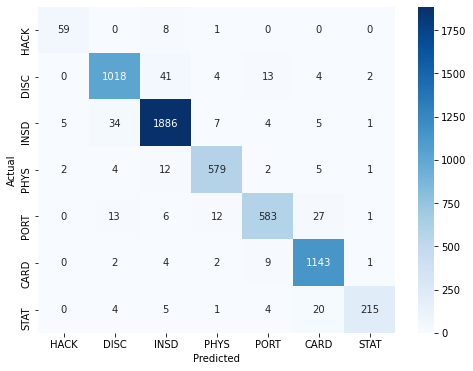

In [10]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
labels = documents['Type of breach'].unique()
conf_mat = confusion_matrix(documents['Type of breach'], y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=labels, yticklabels=labels,cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('confusion_matrix.png', dpi=400)
plt.show()

In [12]:
from sklearn import metrics
report = metrics.classification_report(documents['Type of breach'], y_pred, 
                                    target_names=labels, output_dict=True)
df = pd.DataFrame(report).transpose()

In [13]:
print(df)

              precision    recall  f1-score      support
HACK           0.893939  0.867647  0.880597    68.000000
DISC           0.946977  0.940850  0.943904  1082.000000
INSD           0.961264  0.971164  0.966189  1942.000000
PHYS           0.955446  0.957025  0.956235   605.000000
PORT           0.947967  0.908100  0.927605   642.000000
CARD           0.949336  0.984496  0.966596  1161.000000
STAT           0.972851  0.863454  0.914894   249.000000
accuracy       0.953731  0.953731  0.953731     0.953731
macro avg      0.946826  0.927534  0.936574  5749.000000
weighted avg   0.953774  0.953731  0.953486  5749.000000


In [14]:
print(df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  precision &    recall &  f1-score &      support \\
\midrule
HACK         &   0.893939 &  0.867647 &  0.880597 &    68.000000 \\
DISC         &   0.946977 &  0.940850 &  0.943904 &  1082.000000 \\
INSD         &   0.961264 &  0.971164 &  0.966189 &  1942.000000 \\
PHYS         &   0.955446 &  0.957025 &  0.956235 &   605.000000 \\
PORT         &   0.947967 &  0.908100 &  0.927605 &   642.000000 \\
CARD         &   0.949336 &  0.984496 &  0.966596 &  1161.000000 \\
STAT         &   0.972851 &  0.863454 &  0.914894 &   249.000000 \\
accuracy     &   0.953731 &  0.953731 &  0.953731 &     0.953731 \\
macro avg    &   0.946826 &  0.927534 &  0.936574 &  5749.000000 \\
weighted avg &   0.953774 &  0.953731 &  0.953486 &  5749.000000 \\
\bottomrule
\end{tabular}

